In [117]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [118]:

# 加载数据
X_train = np.load('X_train.npy')  # 特征 (1000, 111)
y_train = np.load('y_train.npy')  # 目标 (1000, 11)


# 转换为Pandas DataFrame以方便处理
df = pd.DataFrame(X_train)
# 检查并填充NaN值
df.fillna(df.mean(), inplace=True)
# 特征缩放
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# 删除所有值都是NaN或0的列
#df_scaled.dropna(axis=1, how='all', inplace=True)
#df_scaled = df_scaled.loc[:, (df_scaled != 0).any(axis=0)]
# 不会有nan了 暂时也不想删掉0 看了一下数据感觉还是保留比较好

# 划分出来百分之二十的测试集
X_train, X_valid, Y_train, Y_valid = train_test_split(df_scaled, y_train, test_size=0.2, random_state=42)

# 将处理后的DataFrame转换回NumPy数组
X_train_processed = X_train.to_numpy()
# 现在X_train_processed是预处理后的数据，可以用于模型训练


In [44]:

'''
# Define the custom loss function
def custom_binary_crossentropy(y_true, y_pred):
    # Compute the binary cross entropy loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    # Take the mean across all labels
    return tf.reduce_mean(bce, axis=-1)

# Compile the model using the custom loss function
model.compile(optimizer='adam', loss=custom_binary_crossentropy, metrics=['accuracy'])

'''
# 似乎是老师定义的loss function？还没仔细看 后面再说吧 先用着binary_crossentropy也可以

"\n# Define the custom loss function\ndef custom_binary_crossentropy(y_true, y_pred):\n    # Compute the binary cross entropy loss\n    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)\n    # Take the mean across all labels\n    return tf.reduce_mean(bce, axis=-1)\n\n# Compile the model using the custom loss function\nmodel.compile(optimizer='adam', loss=custom_binary_crossentropy, metrics=['accuracy'])\n\n"

一个非常简单的神经网络

In [97]:

# 定义模型结构
model = Sequential()
model.add(Dense(128, input_dim=X_train_processed.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(11, activation='sigmoid'))
# 编译模型，添加精确率和召回率指标
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# 训练模型
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid))

# 计算模型在训练集上的精确率和召回率
train_precision = history.history['precision']
train_recall = history.history['recall']

# 计算模型在验证集上的精确率和召回率
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']

# 打印训练集和验证集上的精确率和召回率
print(f'Train Precision: {train_precision[-1]}')
print(f'Train Recall: {train_recall[-1]}')
print(f'Validation Precision: {val_precision[-1]}')
print(f'Validation Recall: {val_recall[-1]}')

Epoch 1/100


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6972 - precision: 0.2646 - recall: 0.3970 - val_loss: 0.6032 - val_precision: 0.1827 - val_recall: 0.0346
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.5984 - precision: 0.3265 - recall: 0.0265 - val_loss: 0.5748 - val_precision: 0.2000 - val_recall: 0.0036
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 0.5591 - precision: 0.7580 - recall: 0.0190 - val_loss: 0.5670 - val_precision: 0.3077 - val_recall: 0.0073
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 0.5495 - precision: 0.6924 - recall: 0.0267 - val_loss: 0.5633 - val_precision: 0.3043 - val_recall: 0.0128
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 0.5321 - precision: 0.7656 - recall: 0.0403 - val_loss: 0.5630 - val_precision: 0.3000 - val_recall: 0.0164
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 0.5233 - precision: 0.8131 - recall: 0.0490 - val_loss: 0.5619 - val_precision: 0.2973 - val_recall: 0.0200


可以明显看出过拟合了 下面尝试加入正则化和drop一些神经元 并且进一步加入了学习率和批量处理大小的自定义

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2


input_dim = X_train.shape[1]  # 获取特征数量

model = Sequential([
    Dense(128, input_dim=input_dim , activation='relu', kernel_regularizer=l2(0.001)),  # 添加L2正则化
    Dropout(0.2),  # 添加Dropout
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),  # 再次添加L2正则化
    Dropout(0.1),  # 添加Dropout
    Dense(32, activation='relu', kernel_regularizer=l2(0.00001)),  # 再次添加L2正则化
    Dense(11, activation='sigmoid')  
])
from keras.optimizers import Adam

# 设置学习率
learning_rate = 0.005 

# 创建优化器实例，应用自定义学习率
optimizer = Adam(learning_rate=learning_rate)


# 之后编译和训练模型
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
# 设置批量处理大小
batch_size = 32

# 训练模型时应用批量处理大小
history =model.fit(X_train, Y_train, batch_size=batch_size, epochs=100, validation_data=(X_valid, Y_valid))


# 计算模型在训练集上的精确率和召回率
train_precision = history.history['precision']
train_recall = history.history['recall']

# 计算模型在验证集上的精确率和召回率
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']

# 打印训练集和验证集上的精确率和召回率
print(f'Train Precision: {train_precision[-1]}')
print(f'Train Recall: {train_recall[-1]}')
print(f'Validation Precision: {val_precision[-1]}')
print(f'Validation Recall: {val_recall[-1]}')

Epoch 1/100


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7527 - precision: 0.2907 - recall: 0.2474 - val_loss: 0.6304 - val_precision: 1.0000 - val_recall: 0.0018
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.6316 - precision: 0.3440 - recall: 0.0022 - val_loss: 0.6129 - val_precision: 0.5000 - val_recall: 0.0018
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 0.5939 - precision: 0.5347 - recall: 0.0074 - val_loss: 0.6013 - val_precision: 0.1667 - val_recall: 0.0018
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.5683 - precision: 0.6815 - recall: 0.0264 - val_loss: 0.6028 - val_precision: 0.3548 - val_recall: 0.0200
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 0.5580 - precision: 0.6893 - recall: 0.0659 - val_loss: 0.5974 - val_precision: 0.4615 - val_recall: 0.0219
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.5368 - precision: 0.6780 - recall: 0.0908 - val_loss: 0.6080 - val_precision: 0.3594 - val_recall: 0.0419


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step


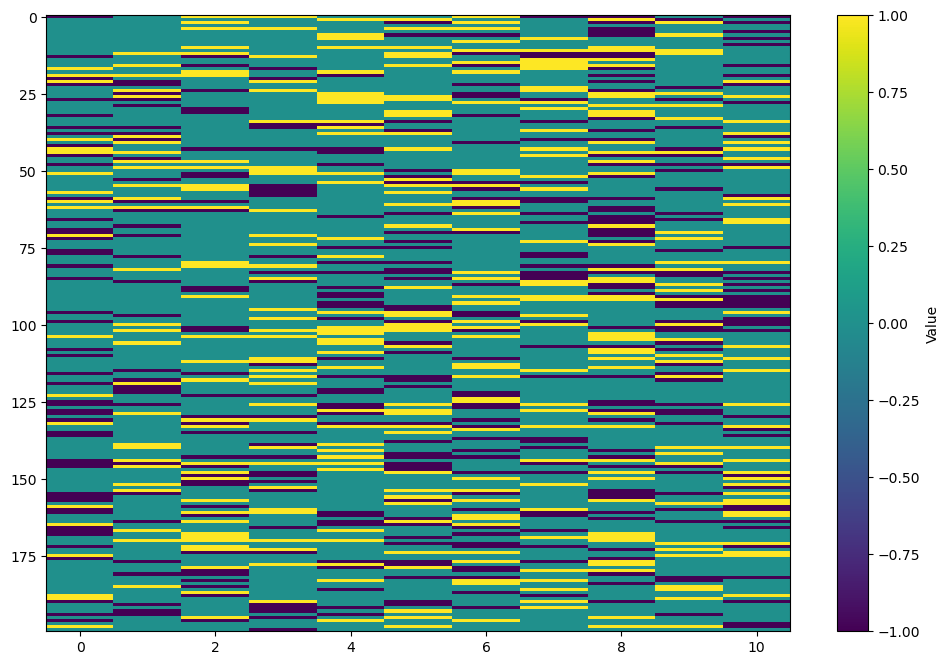

0.3559090909090909
True Positives (TP): 13
False Positives (FP): 20
True Negatives (TN): 118
False Negatives (FN): 49
True Positives (TP): 12
False Positives (FP): 28
True Negatives (TN): 129
False Negatives (FN): 31
True Positives (TP): 6
False Positives (FP): 34
True Negatives (TN): 127
False Negatives (FN): 33
True Positives (TP): 9
False Positives (FP): 34
True Negatives (TN): 128
False Negatives (FN): 29
True Positives (TP): 10
False Positives (FP): 36
True Negatives (TN): 122
False Negatives (FN): 32
True Positives (TP): 11
False Positives (FP): 39
True Negatives (TN): 110
False Negatives (FN): 40
True Positives (TP): 12
False Positives (FP): 39
True Negatives (TN): 110
False Negatives (FN): 39
True Positives (TP): 9
False Positives (FP): 35
True Negatives (TN): 125
False Negatives (FN): 31
True Positives (TP): 26
False Positives (FP): 42
True Negatives (TN): 80
False Negatives (FN): 52
True Positives (TP): 14
False Positives (FP): 31
True Negatives (TN): 118
False Negatives (FN)

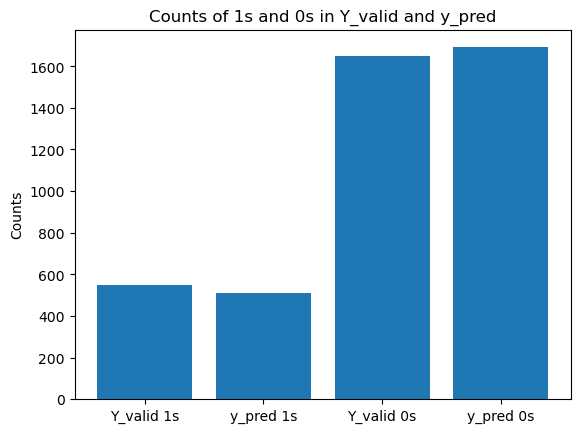

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Y_valid 1s'),
  Text(1, 0, 'y_pred 1 correct'),
  Text(2, 0, 'y_pred 1 incorrect'),
  Text(3, 0, 'Y_valid 0s'),
  Text(4, 0, 'y_pred 0 incorrect'),
  Text(5, 0, 'y_pred 0 correct')])

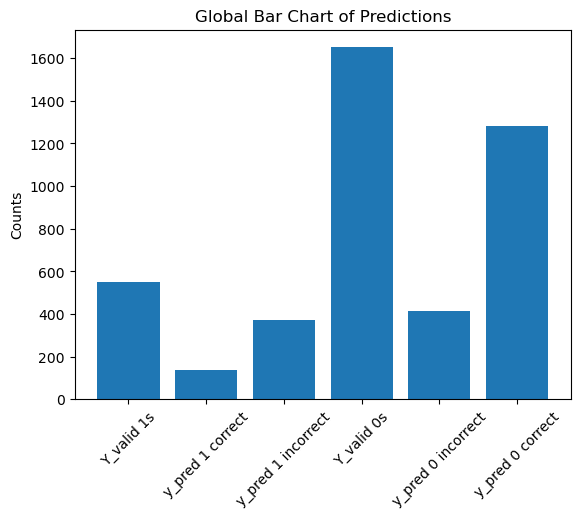

In [124]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 预测
y_pred = model.predict(X_valid)
'''
model内置的好像也是0.5 可能需要后期调整一下
'''
# 假设y_pred是模型的预测结果
threshold = 0.5
y_pred = (y_pred >= threshold).astype(int)

# 热力图 不是很好看
plt.figure(figsize=(12, 8))
plt.imshow(y_pred-Y_valid, aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar(label='Value')
plt.show()

# 可视化
global_TN, global_FP, global_FN, global_TP = 0, 0, 0, 0
# 计算混淆矩阵
for i in range(11):
    
    cm = confusion_matrix(Y_valid[:,i], y_pred[:,i])
    
    # 混淆矩阵返回四个值：[真阴性(TN), 假阳性(FP), 假阴性(FN), 真阳性(TP)]
    TN, FP, FN, TP = cm.ravel()
    
    print(f"True Positives (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Negatives (FN): {FN}")
    
    global_TN += TN
    global_FP += FP
    global_FN += FN
    global_TP += TP
    
y_pred_1_correct = global_TP
y_pred_1_incorrect = global_FP
y_pred_0_correct = global_TN
y_pred_0_incorrect = global_FN

# 计算数量
Y_valid_1_count = np.sum(Y_valid == 1)
Y_valid_0_count = np.sum(Y_valid == 0)
y_pred_1_count = np.sum(y_pred == 1)
y_pred_0_count = np.sum(y_pred == 0)
print(Y_valid_1_count,Y_valid_0_count,y_pred_1_count,y_pred_0_count)

# 绘制条形图
labels = ['Y_valid 1s', 'y_pred 1s', 'Y_valid 0s', 'y_pred 0s']
counts = [Y_valid_1_count, y_pred_1_count, Y_valid_0_count, y_pred_0_count]

plt.bar(labels, counts)
plt.ylabel('Counts')
plt.title('Counts of 1s and 0s in Y_valid and y_pred')
plt.show()


# 绘制条形图
labels = ['Y_valid 1s', 'y_pred 1 correct', 'y_pred 1 incorrect', 'Y_valid 0s', 'y_pred 0 incorrect', 'y_pred 0 correct']
values = [Y_valid_1_count, y_pred_1_correct, y_pred_1_incorrect, Y_valid_0_count, y_pred_0_incorrect, y_pred_0_correct]

plt.bar(labels, values)
plt.ylabel('Counts')
plt.title('Global Bar Chart of Predictions')
plt.xticks(rotation=45)



大概的这么一看的话感觉是第八个目标预测的1太多 貌似最后三个目标预测的不太好不如前面几个
然后Negatives还算比较好 positive不是很行
0 1 的比例还是不错的

In [101]:

from tensorflow.keras.metrics import Metric

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.f1_score = self.add_weight(name='f1', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        self.f1_score = 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))
        return self.f1_score

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()
        self.f1_score.assign(0)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[F1Score()]
)


history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))
val_f1_scores = history.history['val_f1_score']
print(f'Validation F1 Score: {val_f1_scores[-1]}')

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.8680 - loss: 0.3013 - val_f1_score: 0.2687 - val_loss: 1.2523
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - f1_score: 0.8775 - loss: 0.2866 - val_f1_score: 0.2697 - val_loss: 1.2496
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - f1_score: 0.8925 - loss: 0.2645 - val_f1_score: 0.2604 - val_loss: 1.2574
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - f1_score: 0.8901 - loss: 0.2651 - val_f1_score: 0.2576 - val_loss: 1.2596
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - f1_score: 0.8893 - loss: 0.2602 - val_f1_score: 0.2408 - val_loss: 1.2639
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - f1_score: 0.8995 - loss: 0.2564 - val_f1_score: 0.2500 - val_loss: 1.2727
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - f1_score: 0.9075 - loss: 0.2408 - val_f1_score: 0.2572 - val_loss: 1.2799
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.9197 - loss: 0.2351 - val_f1_score: 0.2544